In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *


In [3]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,dirt parking lot,POINT (-105.2320413087213 39.97927552633687)
1,0,tennis court (north),POINT (-105.2320948953668 39.97981893763941)
2,0,tennis court (south),POINT (-105.2321048858712 39.97956622917603)
3,0,red hut,POINT (-105.2320315564236 39.9796903363637)
4,0,grass patch (south),POINT (-105.2319140238961 39.97865502556768)


In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [4]:
reflectance_files_april09, radiance_files_VNIR_april09, radiance_files_SWIR_april09

(['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5'],
 ['../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S2',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S3',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S4',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S5'],
 ['../headwall_data/SWIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../hea

In [5]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1

# these are for the reflectance data
data_file_VNIR = radiance_files_VNIR_april09[hw_ind]
data_file_SWIR = radiance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

# but replace with the radiance data
# these are for the reflectance data
data_file_VNIR = '../headwall_data/raw/radiance/headwall_TIM_block7296_vnir_rad_glt_cor'
data_file_SWIR = '../headwall_data/raw/radiance/headwall_TM_block7443_swir_rad_glt_cor'
data_file_NEON = radiance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

NEON ID:  R10C
../headwall_data/raw/radiance/headwall_TIM_block7296_vnir_rad_glt_cor


In [6]:
## read the data into xarray datasets, chunk with Dask
# first Headwall
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values



In [7]:
# in this case, need to extract out the wavelength information!
band_vnir = xr.open_rasterio(radiance_files_VNIR_april09[hw_ind]).coords['band']
band_swir = xr.open_rasterio(radiance_files_SWIR_april09[hw_ind]).coords['band']

xarr_VNIR.coords['band'] = band_vnir
xarr_SWIR.coords['band'] = band_swir

In [8]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_rad_xarr_from_h5_file(data_file_NEON, nid=neon_id)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Radiance']['Metadata']['Coordinate_System']['Proj4'].value


# Spatial extraction

In [9]:
buffer_dist = 3 # meters

## use the shapefile
pt_index = 0
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)

In [10]:
xarr_NEON.coords

Coordinates:
  * y        (y) float64 4.445e+06 4.445e+06 4.445e+06 ... 4.44e+06 4.44e+06
  * x        (x) float64 4.788e+05 4.788e+05 4.788e+05 ... 4.795e+05 4.795e+05
  * bands    (bands) float64 381.6 386.6 391.6 ... 2.501e+03 2.506e+03 2.511e+03

In [11]:
## do the extraction
neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                (xarr_SWIR, x_swir, y_swir), # they are flipped?!
                                                                pt_df_hw)

neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

(41, 54, 270) (41, 53, 270)
(41, 53, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:242: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


# plot mean of both systems

In [12]:
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)



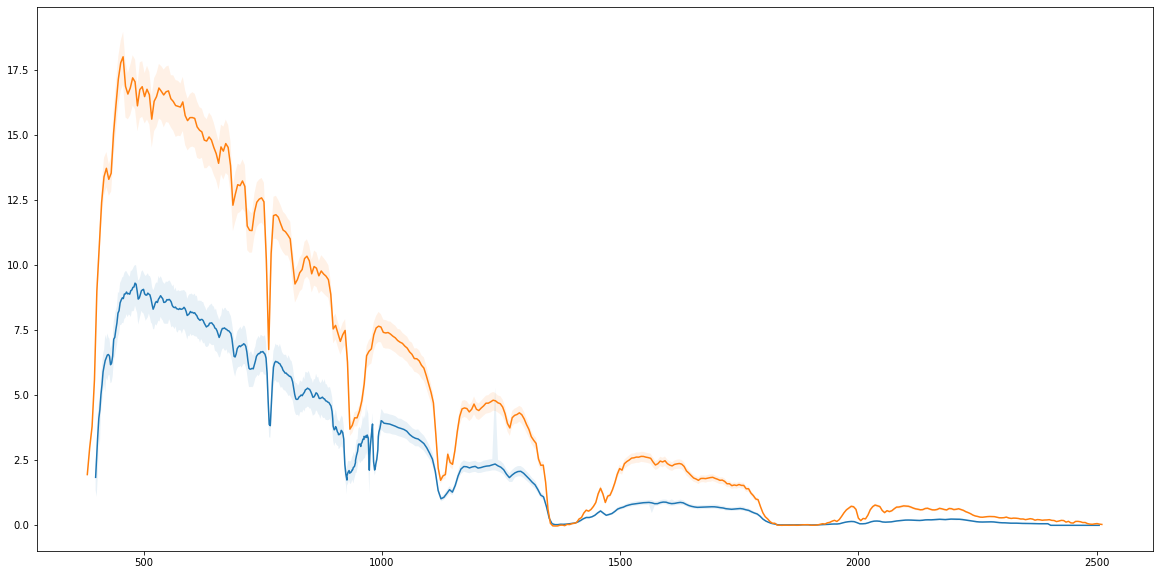

In [13]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean)
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
plt.plot(neon_wav, neon_mean)
plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
plt.show()

In [14]:
## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [15]:
hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


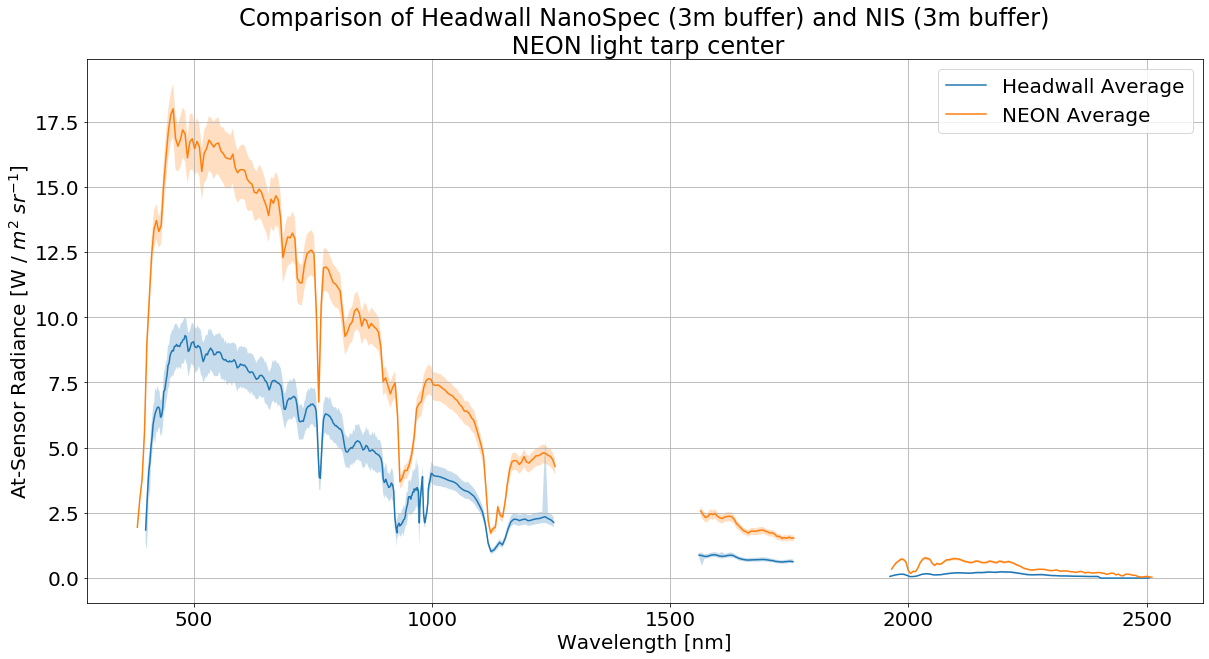

In [16]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n {1}'.format(buffer_dist, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.show()

# load the ASD for the white tarp

In [17]:
# asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp1/0048WhiteTarp1_refl.spectra"
# asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp2/0048WhiteTarp2_refl.spectra"
# asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
# asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')


In [18]:
# ax = asd1.plot(x='wavelength', y='refl', figsize=(20,10), grid=True)
# asd2.plot(x='wavelength', y='refl', figsize=(20,10), grid=True, ax=ax)

# they are pretty close, so just use the first one

In [19]:
# ## mask the water vapor features
# asd_wav = asd1.wavelength.values
# asd_refl = asd1.refl.values
# bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
# asd_refl[bad_asd] = np.nan

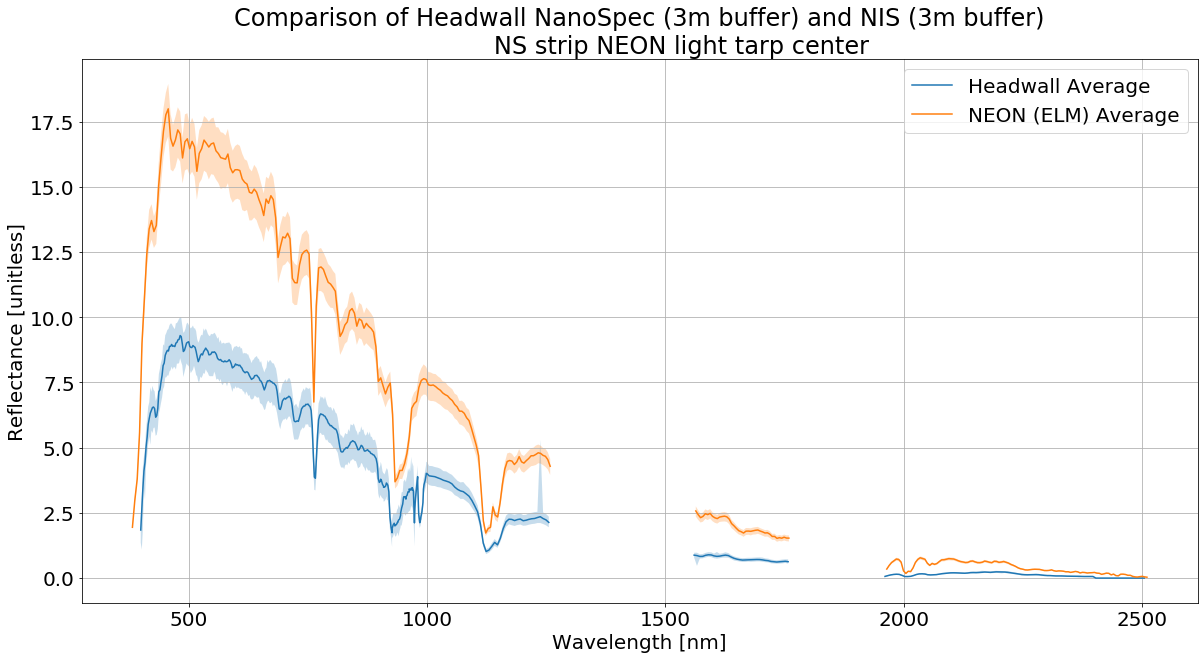

In [20]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# ASD spectra
#plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# do the same for dark tarp

In [21]:
## use the shapefile
pt_index = 1 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


## do the extraction
neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

(41, 53, 270) (42, 53, 270)
(41, 53, 270) (41, 53, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:242: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


In [22]:
# asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
# asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0003BlackTarp1/0003BlackTarp1_refl.spectra"
# asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
# asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

# ## mask the water vapor features
# asd_wav = asd1.wavelength.values
# asd_refl = asd1.refl.values
# bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
# asd_refl[bad_asd] = np.nan

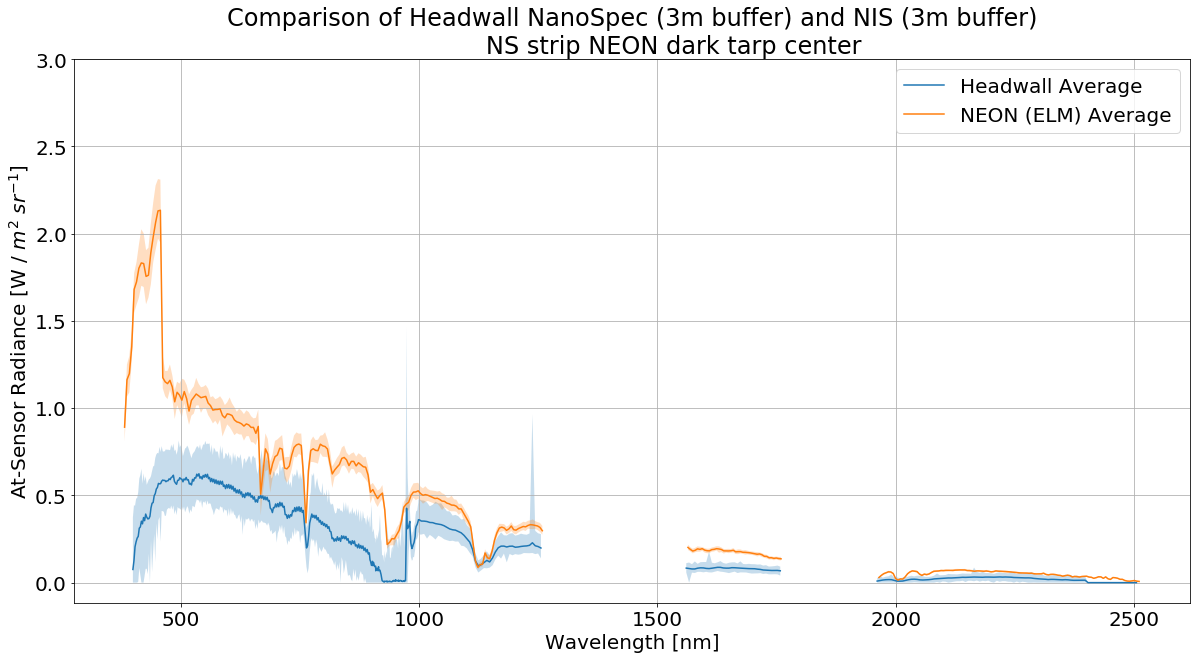

In [23]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# ASD spectra
#plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.ylim(top=3)
plt.show()

# do the same for road sample

In [24]:
## use the shapefile
pt_index = 4 # dark tarp
pt = gdf_4326['geometry'].values[pt_index]
pt_label = gdf_4326['comments'].values[pt_index]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))

# buffer them in the correct coordinate systems
pt_df_hw = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)
pt_df_neon = pt_df.to_crs(epsg=32613).buffer(buffer_dist)


## do the extraction
neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                            (xarr_SWIR, x_swir, y_swir),
                                                            pt_df_hw)

neon_wav, full_neon = neon_arrs
full_wav, full_ex = hw_arrs

hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))


hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

(40, 52, 270) (41, 53, 270)
(40, 52, 270) (40, 52, 270)


D:\projects\headwall_neon\notebooks\xarr_helpers.py:242: UserWarning: extracted shapes are not equal, shaving some off...
  warnings.warn('extracted shapes are not equal, shaving some off...')


In [25]:
# asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/EWRoad1/EWRoad1_refl.spectra"
# asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/EWRoad2/EWRoad2_refl.spectra"
# asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
# asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')

# ## mask the water vapor features
# asd_wav = asd1.wavelength.values
# asd_refl = asd1.refl.values
# bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
# asd_refl[bad_asd] = np.nan

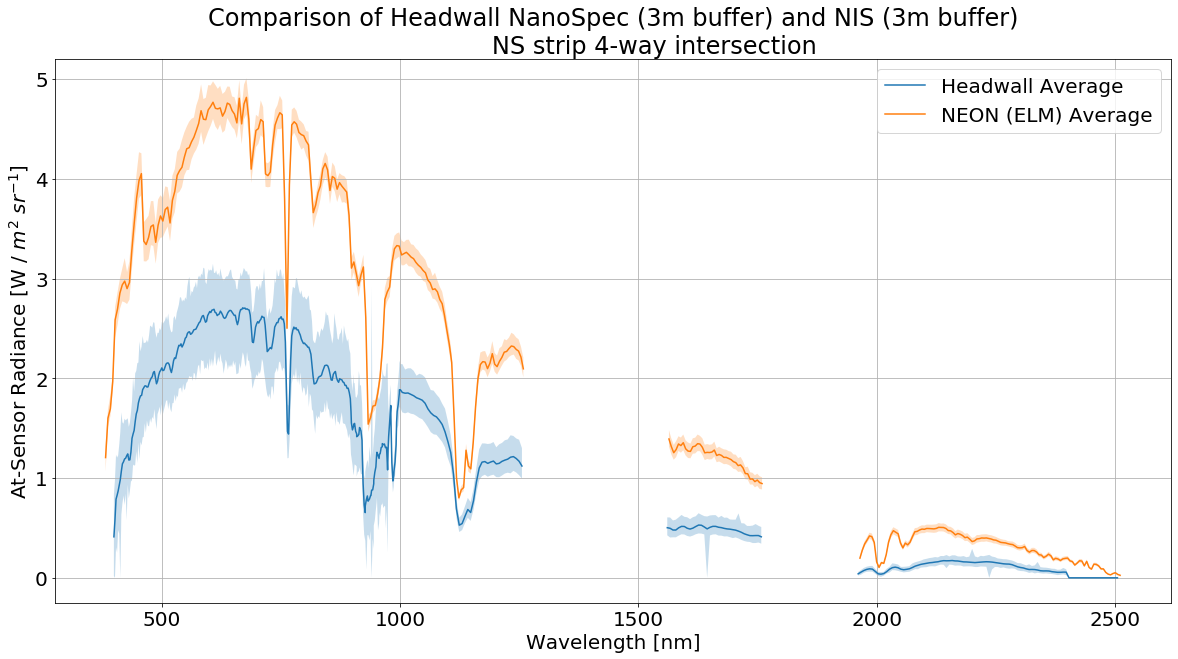

In [29]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON (ELM) Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# ASD spectra
#plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec ({0}m buffer) and NIS ({0}m buffer)\n \
          {1} strip {2}'.format(buffer_dist, fl_dir, pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.ylim(top=5.2)
plt.show()